# Segment Building Footprints in Zanzibar

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from fastai.utils import *
show_install()



```text
=== Software === 
python version  : 3.7.0
fastai version  : 1.0.33
torch version   : 1.0.0.dev20181203
nvidia driver   : 410.78
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7401
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 16278MB | Quadro P5000

=== Environment === 
platform        : Linux-4.4.0-104-generic-x86_64-with-debian-stretch-sid
distro          : #127-Ubuntu SMP Mon Dec 11 12:16:42 UTC 2017
conda env       : fastai-v1
python          : /home/paperspace/anaconda3/envs/fastai-v1/bin/python
sys.path        : /home/paperspace/fastai/course-v3/nbs/dl1/dave-nbs-fastai-p1v3
/home/paperspace/anaconda3/envs/fastai-v1/lib/python37.zip
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/lib-dynload

/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/site-packages
/home/paperspace/anaconda3/envs/fastai-v1/lib/python3.7/site-packag

## Load Data

In [4]:
path = Path('data/znz-segment/znz-train-z19-all-buffered')
path.ls()

[PosixPath('data/znz-segment/znz-train-z19-all-buffered/.DS_Store'),
 PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512'),
 PosixPath('data/znz-segment/znz-train-z19-all-buffered/masks-512')]

In [5]:
path_lbl = path/'masks-512'
path_img = path/'images-512'

In [6]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_043_corrected_19_319466_270800_img.jpg'),
  PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319446_270693_img.jpg'),
  PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_022_19_319421_270662_img.jpg')],
 [PosixPath('data/znz-segment/znz-train-z19-all-buffered/masks-512/grid_036_19_319453_270740_mask_buffered.png'),
  PosixPath('data/znz-segment/znz-train-z19-all-buffered/masks-512/grid_022_19_319432_270669_mask_buffered.png'),
  PosixPath('data/znz-segment/znz-train-z19-all-buffered/masks-512/grid_001_19_319375_270503_mask_buffered.png')])

In [7]:
len(fnames), len(lbl_names)

(2691, 2691)

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem.split("_img")[0]}_mask_buffered.png'

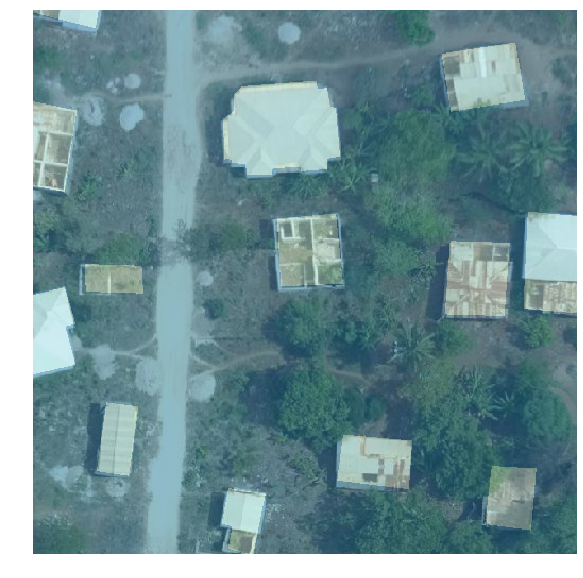

In [9]:
img_f = fnames[-1]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [10]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[512 512]


tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [11]:
size = src_size
bs=8

In [12]:
holdout_grids = ['_028_','_029_','_042_','_058_']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [13]:
codes = np.array(['Empty','Building'])

In [14]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [15]:
src = (SegItemListCustom.from_folder(path_img)
        .split_by_idx(valid_idx)
        .label_from_func(get_y_fn, classes=codes))

In [16]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [17]:
data

ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (2094 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: data/znz-segment/znz-train-z19-all-buffered/images-512
x: SegItemListCustom (2094 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data/znz-segment/znz-train-z19-all-buffered/images-512;

Valid: LabelList
y: SegLabelListCustom (597 items)
[ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512), ImageSegment (1, 512, 512)]...
Path: data/znz-segment/znz-train-z19-all-buffered/images-512
x: SegItemListCustom (597 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: data/znz-segment/znz-train-z19-all-buffered/images-512;

Test: None

In [18]:
data.valid_ds.items

array([PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319446_270693_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_042_19_319434_270798_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319453_270709_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_028_19_319426_270712_img.jpg'), ...,
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319450_270716_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_058_19_319465_270841_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319450_270709_img.jpg'),
       PosixPath('data/znz-segment/znz-train-z19-all-buffered/images-512/grid_028_19_319425_270716_img.jpg')],
      dtype=object)

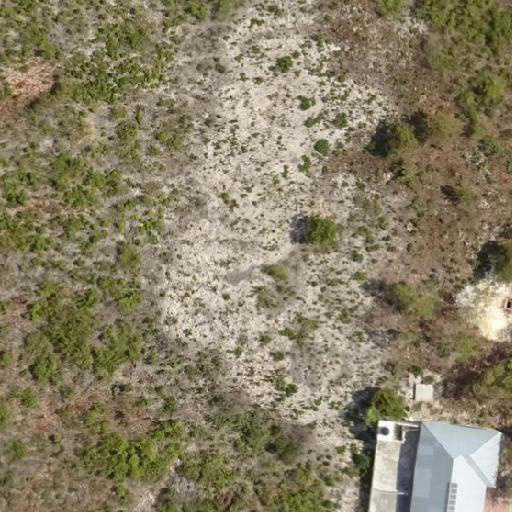

In [19]:
data.train_ds.x[1]

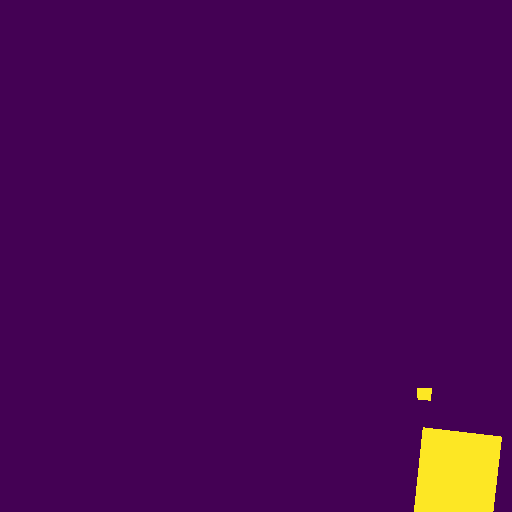

In [20]:
data.train_ds.y[1]

In [21]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

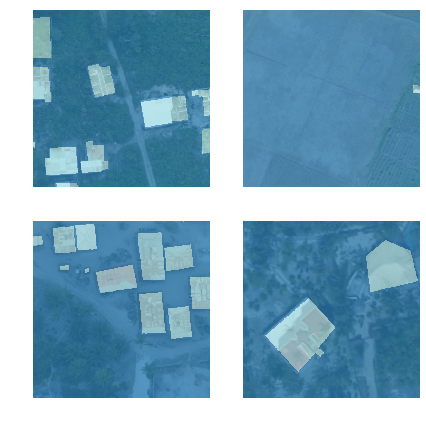

In [22]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

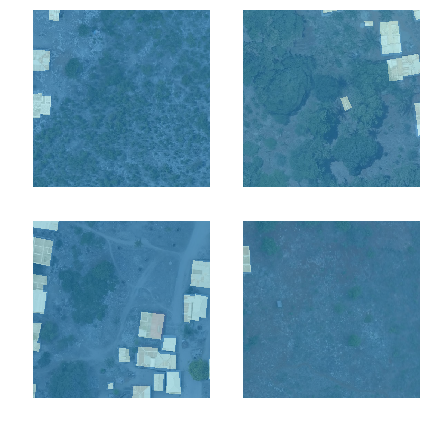

In [23]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

In [24]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

# Custom Loss

In [25]:
import pdb

In [26]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [27]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [28]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [30]:
learn.loss_func

In [31]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [32]:
# learn.opt_func = partial(optim.SGD,momentum=0.9)

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


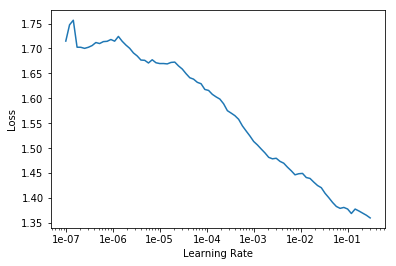

In [35]:
learn.recorder.plot(0,0)

In [32]:
lr = 1e-3

In [36]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [39]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20181205-rn34unet-comboloss-z19_512-best')
                    ]
                   )

saved model at epoch 1 with dice value: 0.7470420002937317
saved model at epoch 2 with dice value: 0.7594106793403625
saved model at epoch 3 with dice value: 0.8235377073287964
saved model at epoch 4 with dice value: 0.8304659724235535
saved model at epoch 5 with dice value: 0.8387457132339478
saved model at epoch 7 with dice value: 0.8481582999229431
saved model at epoch 8 with dice value: 0.8488950729370117


In [33]:
learn.load('20181205-rn34unet-comboloss-z19_512-best')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [34]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [35]:
outputs.shape

torch.Size([8, 2, 512, 512])

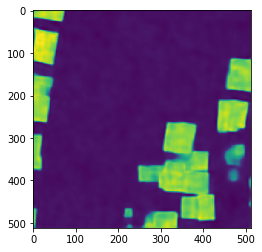

In [36]:
plt.imshow((to_np(outputs[2][1])))

In [37]:
outputs[2][1].sigmoid()

tensor([[0.9855, 0.9831, 0.9884,  ..., 0.1405, 0.1589, 0.1789],
        [0.9838, 0.9816, 0.9873,  ..., 0.1387, 0.1576, 0.1774],
        [0.9897, 0.9881, 0.9901,  ..., 0.1343, 0.1449, 0.1551],
        ...,
        [0.9194, 0.9139, 0.9132,  ..., 0.1564, 0.1648, 0.1724],
        [0.8726, 0.8670, 0.8709,  ..., 0.1627, 0.1762, 0.1889],
        [0.8063, 0.7996, 0.8107,  ..., 0.1682, 0.1879, 0.2073]])

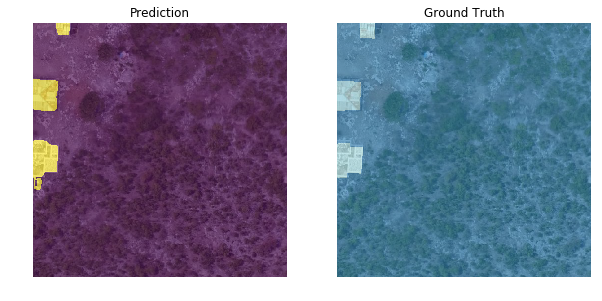

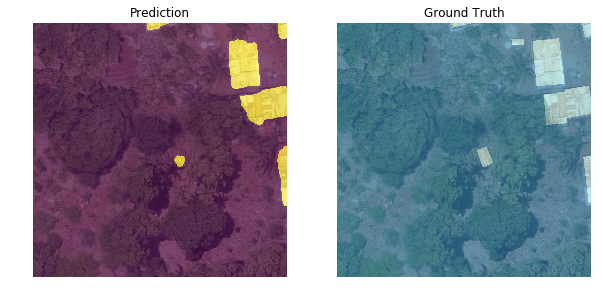

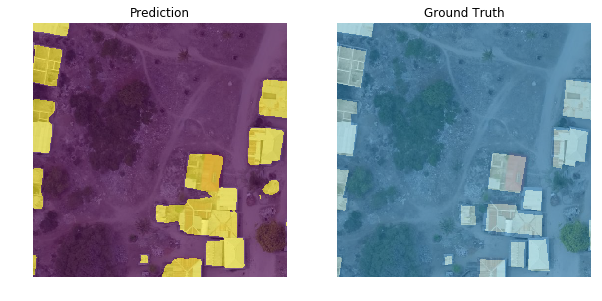

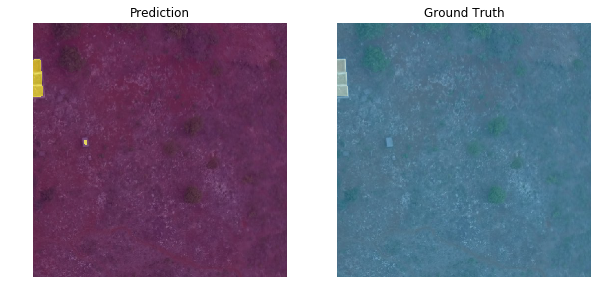

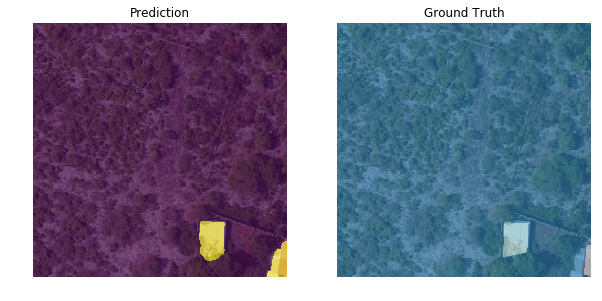

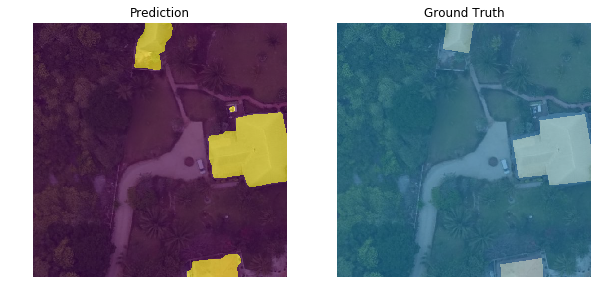

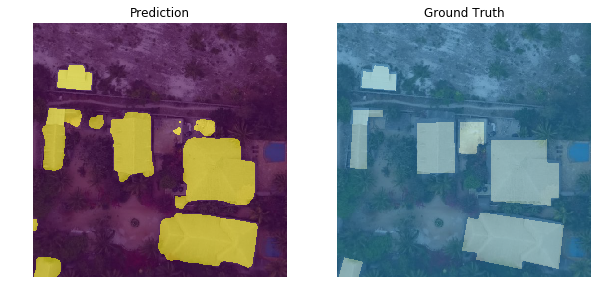

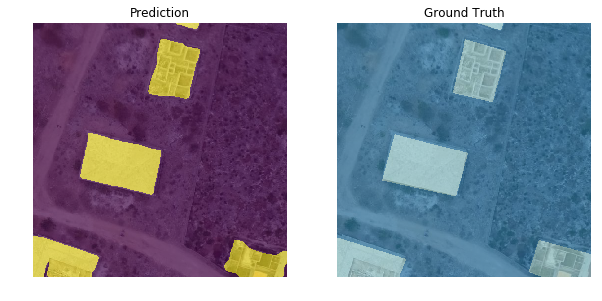

In [38]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()